In [74]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from dateutil import parser
from dateutil.relativedelta import relativedelta
from collections import Counter
import math
from sklearn.metrics import brier_score_loss, mean_squared_error
from scipy.ndimage import uniform_filter

Subsets outlooks, pph, and report data in various ways (add label to each datapoint for each method of subsetting so can be pulled out of full dataset later)


In [5]:
# read in data
data_location = 'data'
labelled = True # if starting with already labelled data
if labelled == True:
    outlooks, pph, reports = read_datasets(data_location, 'labelled')
else:
    outlooks, pph, reports = read_datasets(data_location)

reading outlooks
reading pph
reading storm reports


In [6]:
tz_conversions = {'PST': timedelta(hours=8),
                  'MST': timedelta(hours=7),
                  'CST': timedelta(hours=6),
                  'CSt': timedelta(hours=6),
                  'CSC': timedelta(hours=6),
                  'SCT': timedelta(hours=6),
                  'EST': timedelta(hours=5),
                  'ESt': timedelta(hours=5),
                  'PDT': timedelta(hours=7),
                  'MDT': timedelta(hours=6),
                  'CDT': timedelta(hours=5),
                  'EDT': timedelta(hours=4),
                  'HST': timedelta(hours=10),
                  'SST': timedelta(hours=11),
                  'GST': timedelta(hours=10),
                  'AKS': timedelta(hours=9),
                  'AST': timedelta(hours=4),
                  'UNK': timedelta(hours=5),
                  'GMT': timedelta(0)}

def get_reports_date_strings(date_times, timezones):
    # returns list of strings of date of given datetime and timezone (where day cutoffs are 12-12 UTC) formatted as 'YYYYMMDD0000'
    for datetime, timezone, i in zip(date_times, timezones, range(len(timezones))):
        #print(datetime + ' ' + timezone[:3])
        datetime = parser.parse(datetime)
        datetime = datetime + tz_conversions[timezone[:3]]
        #print(datetime)
        if (datetime.hour < 12):
            datetime = datetime - timedelta(days = 1)
        if datetime.year > 2049:
            datetime = datetime - relativedelta(years = 100)
        datetime = datetime.strftime("%Y%m%d") + '0000'
        if i == 0:
            ret = [datetime]
        else:
            ret.append(datetime)
    return ret

def get_pph_date_strings(times):
    # returns a list of strings of given dates formatted as 'YYYYMMDD0000'
    for datetime, i in zip(times, range(len(times))):
        string = datetime.dt.strftime("%Y%m%d").values + '0000'
        if i == 0:
            ret = [string]
        else:
            ret.append(string)
    return ret

In [7]:
# add dates to reports and pph in same format as in outlooks
if labelled == False:
    reports['DATE'] = get_reports_date_strings(reports['BEGIN_DATE_TIME'], reports['CZ_TIMEZONE']) 
    pph['time'] = get_pph_date_strings(pph.time) 
    # subset outlooks into only one day 1, two day 2, and one day 3 categorical outlooks 
    # day 3: cycle not -1. day 2: cycle not -1. Day 1: cycle 6. Category: categorical.
    outlooks = outlooks[(((outlooks['DAY'] == 1) & (outlooks['CYCLE'] == 6)) | ((outlooks['DAY'] == 2) & (outlooks['CYCLE'] != -1)) | ((outlooks['DAY'] == 3) & (outlooks['CYCLE'] != -1)))
            & (outlooks['CATEGORY'] == 'CATEGORICAL')]

    # reset incicies
    outlooks = outlooks.reset_index(drop=True)

In [8]:
def add_outlooks_label(outlooks, label_dates, labels, label_name, none_label):
    # adds new column with values from labels on the corresponding list of dates in label_dates (DONE)
    print("adding a new column in outlooks")
    outlooks[label_name] = none_label
    for label, dates in zip(labels, label_dates):
        #print(label)
        outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label
    return outlooks

def add_pph_label(pph, label_dates, labels, label_name, none_label):
    # adds new variable with values from labels on the corresponding list of dates in label_dates (DONE)
    print("adding new variable in pph")
    if type(none_label) == str:
        pph[label_name] = (('time'), np.full(len(pph['time']), none_label, dtype='<U16'))
    else:
        pph[label_name] = (('time'), np.full(len(pph['time']), none_label))
    for label, dates in zip(labels, label_dates):
        #print(label) # TODO: only adding limited characters
        pph[label_name].loc[pph['time'].isin(dates)] = label  
    return pph

def add_reports_label(reports, label_dates, labels, label_name, none_label):
    # adds new column with values from labels on the corresponding list of dates in label_dates (DONE)
    reports[label_name] = none_label
    print("adding a new column in reports")
    for label, dates in zip(labels, label_dates):
       #print(label)
       reports[label_name].loc[reports['DATE'].isin(dates)] = label #
    return reports

def add_labels(outlooks, pph, reports, label_dates, labels, label_name, none_label):
    # adds labels, overwriting with later ones if a date has multiple labels
    return(add_outlooks_label(outlooks, label_dates, labels, label_name, none_label), 
           add_pph_label(pph, label_dates, labels, label_name, none_label),
           add_reports_label(reports, label_dates, labels, label_name, none_label))



In [9]:
def add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, dates, values, category_thresholds, name, add_cat = True, add_num = True, num_none_val = 0):
    # from a list of dates and the corresponding values on those dates, adds numerical and categorical labels
    # category thresholds: lower thresholds of each category for values (e.g. 60 for HIGH PPH)
    num_dict = {
        0: []
    }
    cat_dict  = dict((k, []) for k, v in category_thresholds.items())    
        
    for date, value in zip(dates, values):
        # add to categorical dict
        for cat in cat_dict:
            if value >= category_thresholds[cat]:
                cat_dict[cat].append(date)
                break
        
        # add to numerical dict
        if value in num_dict:
            num_dict[value].append(date)
        else:
            num_dict[value] = [date]

    if add_cat:
        (new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, list(cat_dict.values()), cat_dict.keys(), name + '_CAT', 'NONE')
    if add_num:
        (new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, list(num_dict.values()), num_dict.keys(), name + '_NUM', num_none_val)

    return(new_outlooks, new_pph, new_reports)

In [10]:
new_outlooks = outlooks
new_pph = pph
new_reports = reports.drop(columns=['geometry'])

## ALWAYS RUN THROUGH HERE. THEN TO ADD MORE LABELS, RUN JUST THE LABELLING YOU WISH TO BELOW

# Subset by threshold

In [ ]:
# add max threshold forecasted for valid day to each datapoint

categories = ['TSTM', 'MRGL', 'SLGT', 'ENH', 'MDT', 'HIGH']
category_dates = []
for category in categories:
    category_dates.append(identify_dates_above_threshold(new_outlooks, category))

(new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, category_dates, categories, 'MAX_CAT', 'NONE')



# Subset by ramp up/down amount

In [ ]:
# put new_outlooks in correct order

new_outlooks['DATE_ORDER'] = 0
for index, row in new_outlooks.iterrows():
    if row['DAY'] == 3:
        new_outlooks.at[index, 'DATE_ORDER'] = row['DATE'] + '1'
    elif row['DAY'] == 1:
        new_outlooks.at[index, 'DATE_ORDER'] = row['DATE'] + '4'
    elif row['CYCLE'] == 7:
        new_outlooks.at[index, 'DATE_ORDER'] = row['DATE'] + '2'
    else:
        new_outlooks.at[index, 'DATE_ORDER'] = row['DATE'] + '3'
new_outlooks = new_outlooks.sort_values('DATE_ORDER')



In [ ]:
def get_day_3_cutoff(outlooks):
    # returns list of dates in outlooks 
    return outlooks[outlooks['DAY'] == 3]['DATE'].min()

In [ ]:
def create_ramp_lists(outlooks, category_dict):

    first_day_3 = get_day_3_cutoff(outlooks)
    first_day_2_1 = '199707100000'
    first_day_2_2 = '199504040000'

    ramp_ups = {
        0: [],
        1: [],
        2: [],
        3: [],
        4: [],
        5: [],
        6: []
    }

    ramp_downs = {
        0: [],
        -1: [],
        -2: [],
        -3: [],
        -4: [],
        -5: [],
        -6: []
    }

    ramp_categories = {
        'up': [],
        'down': [],
        'both': [],
        'neither': []
    }

    old_date = '0'
    old_do = '0'
    first = True

    for index, row in outlooks.iterrows(): #iterrating through each polygon in the outlook dataset
        cat = category_dict[row['THRESHOLD']]
        do = row['DATE_ORDER']
        date = row['DATE']

        if date != old_date: # New date, save ramp up and ramp down and save alongside old date, then reset ramps, max and min categories seen, and do threshold
            
            
            if first == True:
                first = False
            else:

                if max_cat_do - min_cat_date > ramp_up:
                    ramp_up = max_cat_do - min_cat_date
                if max_cat_do - max_cat_date < ramp_down:
                    ramp_down = max_cat_do - max_cat_date

                if max_cat_do > max_cat_date:
                    max_cat_date = max_cat_do
                if max_cat_do < min_cat_date:
                    min_cat_date = max_cat_do

                ramp_ups[ramp_up].append(old_date)
                ramp_downs[ramp_down].append(old_date)
                if ramp_up > 0 and ramp_down < 0:
                    ramp_categories['both'].append(old_date)
                elif ramp_up > 0:
                    ramp_categories['up'].append(old_date)
                elif ramp_down < 0:
                    ramp_categories['down'].append(old_date)
                else:
                    ramp_categories['neither'].append(old_date)

            old_date = date
            old_do = do
            
            ramp_down = 0
            ramp_up = 0
            max_cat_date = -1
            
    
            if date > first_day_3 and do[-1] == '1': # Since 2002
                min_cat_date = 5 
            elif date > first_day_2_1 and (do[-1] == '2' or do[-1] == '1'): # Since 1997. Check for 1 is in case there is an earlier forecast issued.
                min_cat_date = 5 
            elif date > first_day_2_2 and (do[-1] == '3' or do[-1] == '2' or do[-1] == '1'): # Since 1995
                min_cat_date = 5 
            elif date <= first_day_2_2:
                min_cat_date = 5
            else:
                min_cat_date = -1 # The first outlook on this date was not the earliest forecast it could have been, so it ramped up from no forecast

            max_cat_do = cat


        elif do != old_do: # new outlook, update min and max categories seen, ramp value
            if max_cat_do - min_cat_date > ramp_up:
                ramp_up = max_cat_do - min_cat_date
            if max_cat_do - max_cat_date < ramp_down:
                ramp_down = max_cat_do - max_cat_date

            if max_cat_do > max_cat_date:
                max_cat_date = max_cat_do
            if max_cat_do < min_cat_date:
                min_cat_date = max_cat_do

            old_do = do

            max_cat_do = cat

        else: # Just another threshold within the same polygon
            if cat > max_cat_do:
                max_cat_do = cat
            
        
    # for last iteration
    ramp_ups[ramp_up].append(old_date)
    ramp_downs[ramp_down].append(old_date)
    if ramp_up > 0 and ramp_down < 0:
        ramp_categories['both'].append(old_date)
    elif ramp_up > 0:
        ramp_categories['up'].append(old_date)
    elif ramp_down < 0:
        ramp_categories['down'].append(old_date)
    else:
        ramp_categories['neither'].append(old_date)

    return(ramp_ups, ramp_downs, ramp_categories)


In [ ]:
# define and add ramp category for each datapoint. Potentially add 2 binary ramp up and ramp down (4 options are [up, down, up and down, niether]). How many forecasts to consider for each day? The day 3, both day 2, and the first day 1 (so 4 forecasts ramp)
# dictionary of category to number
category_dict = {
    None : -1,
    'NONE' : -1,
    'TSTM': 0,
    'MRGL': 1,
    'SLGT': 2,
    'ENH': 3,
    'MDT': 4,
    'HIGH': 5
}

(ramp_ups, ramp_downs, ramp_categories) = create_ramp_lists(new_outlooks, category_dict)

In [ ]:

# ramp up
(new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, list(ramp_ups.values()), ramp_ups.keys(), 'RAMP_UP', 0)

# ramp down
(new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, list(ramp_downs.values()), ramp_downs.keys(), 'RAMP_DOWN', 0)

# ramp categories
(new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, list(ramp_categories.values()), ramp_categories.keys(), 'RAMP_CAT', 'neither')


# Subset by accurate/inaccurate

Consider forecast issue time for day 1--subset reports (and revise pph?)--look at other studies to see how they handled multiple day 1 outlooks (see the one in slack). Starting point should be use first forecasts, later ones would be a different analysis for another time. Decide if we should denote these somehow..

# Subset by season

In [ ]:
def get_season_dates(pph):
    dates = list(set(pph['time'].values))
    season_dates = [[], [], [], []]
    for date in dates:
        month = int(date[4:6])
        if month == 12 or month < 3:
            season_dates[0].append(date)
        elif month < 6:
            season_dates[1].append(date)
        elif month < 9:
            season_dates[2].append(date)
        else:
            season_dates[3].append(date)
    return season_dates

In [ ]:
# add column denoting season (4 met seasons as starting point)

seasons = ['Winter', 'Spring', 'Summer', 'Fall']
season_dates = get_season_dates(new_pph)
(new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, season_dates, seasons, 'SEASON', 'NONE')


# Subset by region

In [ ]:
# decide how to do... lower priotity, could do by state of center of highest category (or center of PPH?) Could start with super basic version
# same regions as Anderson-Frey 2016
# center is grid square with highest p_perfect prob of at least one hazard (assuming each hazard in independent)

# practically perfect probability of at least one hazard occuring near datapoint
new_pph['p_perfect_total'] = (1 - (1-new_pph['p_perfect_wind']/100)*(1-new_pph['p_perfect_hail']/100)*(1-new_pph['p_perfect_tor']/100))*100


In [ ]:
# collect regions in chunks (since doing it all at once can time out)
regions = {
        'West': [],
        'Midwest': [],
        'Great Plains': [],
        'Northeast': [],
        'South': [],
        'NONE': []
    }


In [ ]:
def get_state(lat, lon, geolocator):
    location = geolocator.reverse(str(lat)+","+str(lon))
    if location == None:
        return None
    address = location.raw['address']
    state = address.get('state', '')
    return state

def get_region(lat, lon, west_threshold_co_nm, regions_dict, geolocator):
    state = get_state(lat, lon, geolocator)
    if state == 'Colorado' or state == 'New Mexico':
        if lon < west_threshold_co_nm:
            return('West')
        else:
            return('Great Plains')
    for region in regions_dict:
        if state in regions_dict[region]:
            return region
    # Cases where highest PPH is out of contiguous states, usually just outside bc nearest gridpoint is on other side of border
    if lat > 38:
        if lon > -80.5:
            return('Northeast')
        elif lon > -104:
            return('Great Plains')
        else:
            return('West')
    else:
        if lon > -93.8:
            return('South')
        elif lon > -106.5:
            return('Great Plains')
        else:
            return('West')
    return('NONE')


def create_regions(pph):
    regions = {
        'West': [],
        'Midwest': [],
        'Great Plains': [],
        'Northeast': [],
        'South': [],
        'NONE': []
    }

    geolocator = Nominatim(user_agent="severe_thunderstorm_miles")
    west_threshold_co_nm = -105
    regions_dict = { # list of states fully within each region (doesn't include AK, HI, CO, NM)
        'West': ['Washington', 'Oregon', 'California', 'Idaho', 'Montana', 'Wyoming', 'Utah', 'Arizona'],
        'Midwest': ['North Dakota', 'South Dakota', 'Minnesota', 'Iowa', 'Wisconsin', 'Illinois', 'Michigan', 'Indiana', 'Ohio', 'Kentucky'],
        'Great Plains': ['Nebraska', 'Kansas', 'Oklahoma', 'Texas', 'Missouri'],
        'Northeast': ['Maine', 'Vermont', 'New Hampshire', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey', 'Delaware', 'Maryland', 'District of Columbia', 'West Virginia'],
        'South': ['Virginia', 'Arkansas', 'Louisiana', 'Tennessee', 'Mississippi', 'Alabama', 'Georgia', 'North Carolina', 'South Carolina', 'Florida']
    }

    old_year = ''
    for date, date_pph in pph.groupby('time'):
        if date_pph['p_perfect_total'].max() > 0:
            year = date[0:4]
            if year != old_year:
                print("Finding regions for " + year)
                old_year = year
            max_coords = date_pph['p_perfect_total'].argmax(dim = ['x', 'y'])
            max_x_coord = max_coords['x'].values
            max_y_coord = max_coords['y'].values
            lat = date_pph['lat'].loc[dict(x = max_x_coord, y = max_y_coord)].values
            lon = date_pph['lon'].loc[dict(x = max_x_coord, y = max_y_coord)].values
            region = get_region(lat, lon, west_threshold_co_nm, regions_dict, geolocator)
            regions[region].append(date)
            
    return(regions)

In [ ]:
chunks = 10
time_array = new_pph['time']
chunk_size = math.ceil(len(time_array)/chunks)
time_arrays = [time_array[i:i + chunk_size] for i in range(0, len(time_array), chunk_size)]
for i in range(chunks):
    chunk_regions = create_regions(new_pph.sel(time = time_arrays[i]))
    for region in regions:
        regions[region] += chunk_regions[region]
    print('Added chunk ' + str(i) + ' to regions')

In [ ]:
(new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, list(regions.values()), regions.keys(), 'REGION', 'NONE')

# Subset by environmental data (to do later)

In [ ]:
pph

# Label by max total pph

In [ ]:
# testing add numerical_categorical_columns
dates = []
pphs = []
for date, date_pph in pph.groupby('time'):
    dates.append(date)
    pphs.append(float(date_pph['p_perfect_total'].max().values))

pph_thresholds = { 
    'HIGH': 60,
    'MDT': 45,
    'ENH': 30,
    'SLGT': 15,
    'MRGL': 5,
    'ZERO': 0
}

In [ ]:
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, dates, pphs, pph_thresholds, 'PPH', num_none_val = 0.0)

# Label by number of storm reports

In [ ]:
reports_severe = new_reports
new_reports.loc[new_reports['MAGNITUDE'] == '', 'MAGNITUDE'] = 0
reports_severe = reports_severe[(reports_severe['EVENT_TYPE'] == 'Tornado') | 
                             ((reports_severe['EVENT_TYPE'] == 'Thunderstorm Wind') & (reports_severe['MAGNITUDE'].astype(float) >= 50)) |
                             ((reports_severe['EVENT_TYPE'] == 'Hail') & (reports_severe['MAGNITUDE'].astype(float) >= 1))]
full_dates = reports_severe['DATE']
c = Counter(full_dates)

num_reports_thresholds = {
    '1000': 1000,
    '500': 500,
    '100': 100,
    '50': 50,
    '10': 10,
    '1': 1,
    '0': 0
}
    

In [ ]:
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, c.keys(), c.values(), num_reports_thresholds, 'REPORT', add_cat = False)

# Label by number of each type of report

In [ ]:
tornado_reports = new_reports[new_reports['EVENT_TYPE'] == 'Tornado']

wind_reports = reports_severe[reports_severe['EVENT_TYPE'] == 'Thunderstorm Wind']

hail_reports = reports_severe[reports_severe['EVENT_TYPE'] == 'Hail']

In [ ]:
tornado_dates = tornado_reports['DATE']
tornado_c = Counter(tornado_dates)

wind_dates = wind_reports['DATE']
wind_c = Counter(wind_dates)

hail_dates = hail_reports['DATE']
hail_c = Counter(hail_dates)

new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, tornado_c.keys(), tornado_c.values(), num_reports_thresholds, 'TOR', add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, wind_c.keys(), wind_c.values(), num_reports_thresholds, 'WIND', add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, hail_c.keys(), hail_c.values(), num_reports_thresholds, 'HAIL', add_cat = False)

# Label by size of largest report of each type

In [ ]:
# tor: Categorical. Decide if we want to combine f and ef max 
strongest_tornadoes = tornado_reports.groupby('DATE').agg({'TOR_F_SCALE': 'max'})['TOR_F_SCALE']
strongest_tornadoes_without_u = tornado_reports[tornado_reports['TOR_F_SCALE'] != 'EFU'].groupby('DATE').agg({'TOR_F_SCALE': 'max'})['TOR_F_SCALE']

tornado_strengths = {
    'EFU': [],
    '(E)F0': [],
    '(E)F1': [],
    '(E)F2': [],
    '(E)F3': [],
    '(E)F4': [],
    '(E)F5': []
}
for date, s in zip(strongest_tornadoes.index, strongest_tornadoes):
    if s == 'EFU':
        if date in strongest_tornadoes_without_u:
            tornado_strengths['(E)F' + strongest_tornadoes_without_u[date][-1]].append(date)
        else:
            tornado_strengths['EFU'].append(date)

    elif s != '':
        tornado_strengths['(E)F' + s[-1]].append(date)

(new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, list(tornado_strengths.values()), tornado_strengths.keys(), 'TOR_F', 'NONE')

In [ ]:
# both wind and hail have a few weird outliers: Wind all pre-2000. Hail has 2 0.00 and 1 0.01 in 2005. Unmeasured wind reports are 50 (knots)
winds = wind_reports.groupby('DATE').agg({'MAGNITUDE': 'max'})
hails = hail_reports.groupby('DATE').agg({'MAGNITUDE': 'max'})

In [ ]:
wind_thresholds = {
    'sig_severe': 65,
    'severe': 50,
    'NONE': 0
}

hail_thresholds = {
    'sig_severe': 2,
    'severe': 1,
    'NONE': 0
}

In [ ]:
add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, winds.index, winds.astype(float)['MAGNITUDE'].values, wind_thresholds, 'WINDSP', num_none_val = 0.0)
add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, hails.index, hails.astype(float)['MAGNITUDE'].values, hail_thresholds, 'HAILSZ', num_none_val = 0.0)

# Label by accuracy of forecast
Brier, FSS, SAL, and/or wavelet

In [14]:
# Need gridded outlooks and reports
grid_outlook_location = 'data/outlooks/grid_outlooks.nc'
grid_report_location = 'data/storm_reports/grid_reports.nc'

grid_outlooks = xr.open_dataset(grid_outlook_location)
grid_reports = xr.open_dataset(grid_report_location)
grid_outlooks['time'] = get_pph_date_strings(grid_outlooks['time'])


# Brier Score

In [59]:
def brier_score(grid_outlooks, grid_reports, outlook_day_str = 'Day 1', report_type_str = 'Total Reports'):
    go = grid_outlooks.sel(outlook = outlook_day_str)
    gr = grid_reports.sel(hazard = report_type_str)
    scores = []
    for date in grid_outlooks['time']:
        outlooks = go.sel(time = date)['prob'].data.flatten()
        verification = gr.sel(time = date)['bool'].data.flatten()
        scores.append(brier_score_loss(verification, outlooks))
    return(scores)

bs = brier_score(grid_outlooks, grid_reports)

In [2]:
add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'], bs, {}, 'BS_DAY_1', num_none_val = 0.0, add_cat = False)


# Neighborhood probabilistic verification

In [63]:
# smooth (with variable neighborhood size) and then do brier score
def neighborhood_verification(grid_outlooks, grid_reports, neighborhood_size, outlook_day_str = 'Day 1', report_type_str = 'Total Reports'):
    go = grid_outlooks.sel(outlook = outlook_day_str)
    gr = grid_reports.sel(hazard = report_type_str)
    scores = []
    for date in grid_outlooks['time']:
        outlooks = uniform_filter(go.sel(time = date)['prob'], size=neighborhood_size, mode='constant')
        verification = uniform_filter(gr.sel(time = date)['bool'].astype(float), size=neighborhood_size, mode='constant')
        scores.append(np.mean((outlooks - verification) ** 2))
    return scores
npv = neighborhood_verification(grid_outlooks, grid_reports, 5)

In [ ]:
add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'], npv, {}, 'NEIGHBORHOOD_VER', num_none_val = 0.0, add_cat = False)

# RMSE between outlooks and PPH

In [83]:
# do rmse
def rmse_verification(grid_outlooks, pph, outlook_day_str = 'Day 1', pph_hazard_str = 'total'):
    go = grid_outlooks.sel(outlook = outlook_day_str)
    scores = []
    for date in grid_outlooks['time']:
        outlooks = go.sel(time = date)['prob']
        p = pph.sel(time = date)['p_perfect_' + pph_hazard_str]/100
        scores.append(mean_squared_error(p, outlooks, squared=False))
    return(scores)
        
rmse = rmse_verification(grid_outlooks, pph)

In [ ]:
add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'], rmse, {}, 'RMSE_VER', num_none_val = 0.0, add_cat = False)

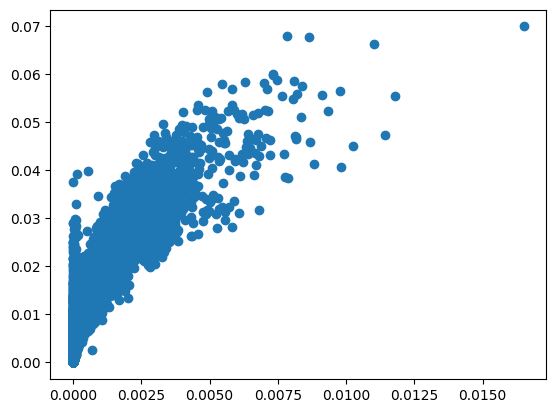

In [84]:
# once grid outlooks updated, see with day 1
# plt.scatter(bs, npv)
a = neighborhood_verification(grid_outlooks, grid_reports, 5, outlook_day_str='Day 3')
b = brier_score(grid_outlooks, grid_reports, outlook_day_str= 'Day 3')
c = rmse_verification(grid_outlooks, new_pph, outlook_day_str='Day 3')
plt.scatter(b, c)

# More Advanced Methods (SAL, wavelets?)

In [13]:
# More advanced methods
new_outlooks

,ISSUE,EXPIRE,PRODISS,TYPE,DAY,THRESHOLD,CATEGORY,CYCLE,DATE,MAX_CAT,...,REPORT_NUM,TOR_NUM,WIND_NUM,HAIL_NUM,TOR_F,WINDSP_CAT,WINDSP_NUM,HAILSZ_CAT,HAILSZ_NUM,geometry
0,198701161200,198701171200,198701160615,C,1,TSTM,CATEGORICAL,6,198701160000,TSTM,...,0,0,0,0,NONE,NONE,0.0,NONE,0.0,"POLYGON ((-81.10300 30.60200, -81.08700 30.521..."
1,198701271200,198701281200,198701270643,C,1,TSTM,CATEGORICAL,6,198701270000,TSTM,...,0,0,0,0,NONE,NONE,0.0,NONE,0.0,"POLYGON ((-119.01700 33.49500, -119.54500 34.0..."
2,198701281200,198701291200,198701280631,C,1,TSTM,CATEGORICAL,6,198701280000,TSTM,...,0,0,0,0,NONE,NONE,0.0,NONE,0.0,"MULTIPOLYGON (((-123.71244 38.67008, -123.7150..."
3,198701291200,198701301200,198701290631,C,1,TSTM,CATEGORICAL,6,198701290000,TSTM,...,0,0,0,0,NONE,NONE,0.0,NONE,0.0,"MULTIPOLYGON (((-123.71500 38.67200, -123.7230..."
4,198701301200,198701311200,198701300636,C,1,TSTM,CATEGORICAL,6,198701300000,TSTM,...,0,0,0,0,NONE,NONE,0.0,NONE,0.0,"POLYGON ((-103.95573 29.30252, -103.97500 29.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62396,202312301200,202312311200,202312280746,C,3,TSTM,CATEGORICAL,8,202312300000,TSTM,...,0,0,0,0,NONE,NONE,0.0,NONE,0.0,"POLYGON ((-120.67500 33.78700, -121.27500 33.6..."
62397,202312301200,202312311200,202312290600,C,2,TSTM,CATEGORICAL,7,202312300000,TSTM,...,0,0,0,0,NONE,NONE,0.0,NONE,0.0,"POLYGON ((-119.53500 33.98700, -120.06600 33.9..."
62398,202312301200,202312311200,202312291644,C,2,TSTM,CATEGORICAL,17,202312300000,TSTM,...,0,0,0,0,NONE,NONE,0.0,NONE,0.0,"POLYGON ((-119.53500 33.98700, -120.06600 33.9..."
62399,202312311200,202401011200,202312290818,C,3,TSTM,CATEGORICAL,8,202312310000,TSTM,...,0,0,0,0,NONE,NONE,0.0,NONE,0.0,"POLYGON ((-92.16400 29.18100, -92.62900 29.233..."


# SAVE DATA

In [ ]:
# resave labelled data
outlook_save_location = 'data/outlooks'
pph_save_location = 'data/pph'
report_save_location = 'data/storm_reports'

new_outlooks.to_file(outlook_save_location + '/labelled_outlooks.shp')
if labelled == True:
    new_pph.to_netcdf(pph_save_location + '/labelled_pph2.nc') 
else:
    new_pph.to_netcdf(pph_save_location + '/labelled_pph.nc') 
new_reports.to_csv(report_save_location + '/labelled_reports.csv')

# REMOVING COLUMNS (if needed)

In [ ]:
columns_to_remove = ['RAMP_CATEG', 'MAX_PPH_CA', 'MAX_PPH_NU',
       'NUM_REPORT', 'TOR_REPORT', 'WIND_REPOR', 'HAIL_REPOR', 'MAX_TORNAD',
       'MAX_WIND_S', 'MAX_WIND_1', 'MAX_HAIL_S', 'MAX_HAIL_1']
#new_outlooks = new_outlooks.drop(columns = columns_to_remove)
#new_reports = new_reports.drop(columns = columns_to_remove)
#new_pph = new_pph.drop_vars(columns_to_remove)
new_pph['WINDSP_CAT'].values

# Relabelling existing columns (if needed)

In [ ]:
# lengthen strings in region, severity 
labels1 = {
    'West': [],
    'Midwest': [],
    'Great Plains': [],
    'Northeast': [],
    'South': [],
    'NONE': []
}
for date, region in zip(new_pph['time'].values, new_pph['REGION'].values):
    if region == 'Northeas':
        labels1['Northeast'].append(date)
    elif region == 'Great Pl':
        labels1['Great Plains'].append(date)
    else:
        labels1[region].append(date)


labels2 = {
    'sig_severe': [],
    'severe': [],
    'NONE': []
}
for date, cat in zip(new_pph['time'].values, new_pph['WINDSP_CAT'].values):
    if cat == 'sig_seve':
        labels2['sig_severe'].append(date)
    else:
        labels2[cat].append(date)


labels3 = {
    'sig_severe': [],
    'severe': [],
    'NONE': []
}
for date, cat in zip(new_pph['time'].values, new_pph['HAILSZ_CAT'].values):
    if cat == 'sig_seve':
        labels3['sig_severe'].append(date)
    else:
        labels3[cat].append(date)

In [ ]:
new_outlooks, new_pph, new_reports = add_labels(new_outlooks, new_pph, new_reports, labels1.values(), labels1.keys(), 'REGION', 'NONE')
new_outlooks, new_pph, new_reports = add_labels(new_outlooks, new_pph, new_reports, labels2.values(), labels2.keys(), 'WINDSP_CAT', 'NONE')
new_outlooks, new_pph, new_reports = add_labels(new_outlooks, new_pph, new_reports, labels3.values(), labels3.keys(), 'HAILSZ_CAT', 'NONE')

In [ ]:
pph